In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC

# Classifcation traffic sign using Support Vector Machine

In [ ]:
img_list = []
label_list = []
annotations_dir = "/content/drive/MyDrive/Machine_Learning/traffic_sign_detection/annotations"
image_dir = "/content/drive/MyDrive/Machine_Learning/traffic_sign_detection/images"
for annotation_name in os.listdir(annotations_dir):
    tree = ET.parse(annotations_dir + "/" + annotation_name)
    root = tree.getroot()
    file_name = root.find("filename").text
    img = cv2.imread(image_dir + "/" + file_name)
    for obj in root.findall("object"):
        label = obj.find("name").text
        if label == "trafficlight": continue
        x_min = int(obj.find("bndbox/xmin").text)
        y_min = int(obj.find("bndbox/ymin").text)
        x_max = int(obj.find("bndbox/xmax").text)
        y_max = int(obj.find("bndbox/ymax").text)
        object_img = img[y_min: y_max, x_min: x_max]
        img_list.append(object_img)
        label_list.append(label)
print(len(img_list))
print(list(set(label_list)))

1074
['crosswalk', 'stop', 'speedlimit']


In [ ]:
def preprocessingImg(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)
    img = resize\
    (
        image = img,
        output_shape = (32, 32),
        anti_aliasing = True
    )

    hog = feature.hog\
    (
        image = img,
        orientations = 9,
        pixels_per_cell = (8, 8),
        cells_per_block = (2, 2),
        block_norm = "L2",
        feature_vector = True
    )
    return hog
feature_img = []
for img in img_list:
    hog_img = preprocessingImg(img)
    feature_img.append(hog_img)
feature_img = np.array(feature_img)

In [ ]:
label_encoder = LabelEncoder()
label_list = label_encoder.fit_transform(label_list)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(feature_img, label_list, test_size = 0.3, shuffle = True)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
model = SVC(C = 0.5, kernel = 'rbf', probability = True)
model.fit(x_train, y_train)

SVC(C=0.5, probability=True)

In [ ]:
y_pred = model.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

Accuracy score: 0.9628482972136223


[5.79649795e-10 9.99973645e-01 2.63541713e-05]


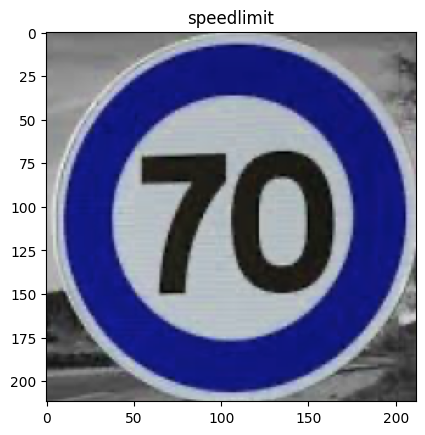

In [ ]:
img = img_list[25]
normalize_img = preprocessingImg(img)
idx_pred = model.predict_proba([normalize_img])[0]
print(idx_pred)
pred = np.argmax(idx_pred)
label = ["crosswalk", "speedlimit", "stop"]
plt.title(label[pred])
plt.imshow(img)
plt.show()

# Object detection using Sliding window

In [ ]:
def slidingWindow(img, window_size, stride, scale_factor):
    img_height, img_width = img.shape[: 2]
    window_list = []
    for window in window_size:
        window_height, window_width = window
        for ymin in range(0, img_height - window_height, stride):
            for xmin in range(0, img_width - window_width, stride):
                xmax = int(xmin + window_width)
                ymax = int(ymin + window_height)
                window_list.append([xmin, ymin, xmax, ymax])
    return window_list

In [ ]:
def pyramidImg(img, min_size = (30, 30), scale_factor = 0.8):
    acc_scale = 1.0
    pyramid_img_list = [[img, acc_scale]]
    i = 0
    while True:
        acc_scale *= scale_factor
        width = int(img.shape[1] * scale_factor)
        height = int(img.shape[0] * scale_factor)
        if width < min_size[1] or height < min_size[0]: break
        img = cv2.resize(img, (width, height))
        pyramid_img_list.append([img, acc_scale * (scale_factor ** i)])
        i += 1
    return pyramid_img_list

In [ ]:
def visualizebbox(img, bbox_list, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for bbox in bbox_list:
        xmin, ymin, xmax, ymax, predicted_id, conf_score = bbox
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        label = label_encoder.inverse_transform([predicted_id])[0]
        class_name = ["crosswalk", "speedlimit", "stop"]
        text = f"{class_name[label]}: {conf_score}"
        (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    plt.imshow(img)
    plt.show()

In [ ]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

In [ ]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]
    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)
    keep = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

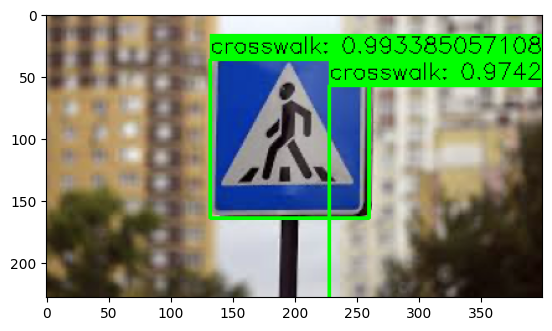

Time process:  11.122418642044067


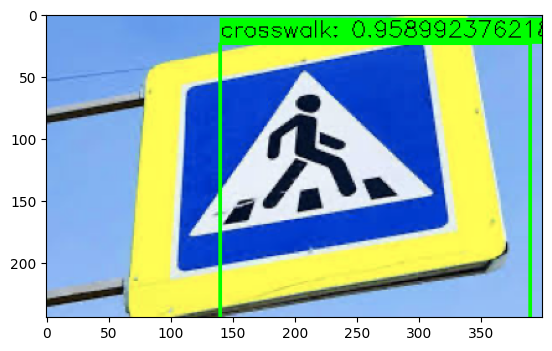

Time process:  14.456588983535767


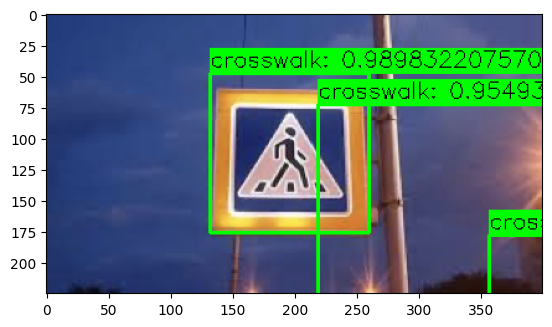

Time process:  5.046404838562012


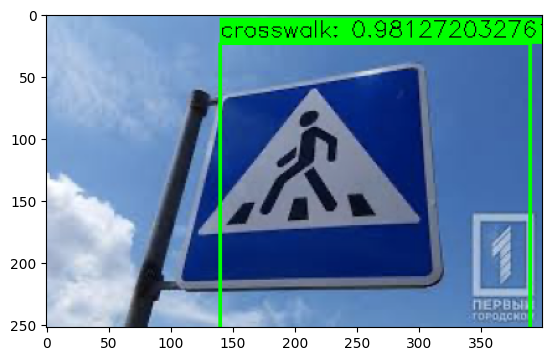

Time process:  6.0421459674835205


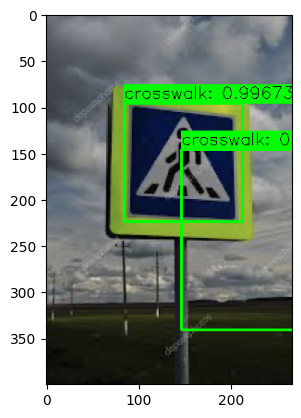

Time process:  4.820535182952881


In [ ]:
import time
img_dir = '/content/drive/MyDrive/Machine_Learning/traffic_sign_detection/images'
img_filename_lst = os.listdir(img_dir)[25: 30]
conf_threshold = 0.95
iou_threshold = 0.2
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    # print("Name image: " + img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramidImg(img)
    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = slidingWindow(
            pyramid_img,
            window_sizes,
            stride,
            scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocessingImg(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            result = model.predict_proba([normalized_img])[0]
            if np.all(result < conf_threshold):continue
            predict_id = np.argmax(result)
            conf_score = result[predict_id]
            xmin //= scale_factor
            ymin //= scale_factor
            xmax //= scale_factor
            ymax //= scale_factor
            bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
    bboxes = nms(bboxes, iou_threshold)
    visualizebbox(img, bboxes, label_encoder)
    print('Time process: ', time.time() - start_time)